# Cantera module for Flamelet Generated Manifolds
## part 2: series of flamelets
We are going to run a series of free flames, visualise them and create an FGM for ANSYS Fluent. 
As always, go through this interactive notebook in jupyter (jupyter labs or jupyter notebook) and follow the instructions. You can execute the selected cell one by one using the play button at the top or pressing SHIFT+ENTER.
First we load the necessary libraries.
For help on the commands see https://cantera.org/documentation/

In [ ]:
# use this for standard jupyter notebook
#%matplotlib inline
# with a local install you can use qt5 and get pop-up windows with interactive graphics (pan, zoom, edit)
%matplotlib qt5

matplotlib inline will embed the figures in your notebook document. 

If qt5 is installed (not on the online binder unfortunately), figures will be created in an interactive external window

In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

We will need some interpolation routines to create results with the same number of points in the progress variable direction

In [27]:
# linearly interpolate and get T at point p using input data (x,T)
def interpoint(p,x,T):
    if (p<x[0] or p>x[len(x)-1]):
        raise ValueError("point p=",p," is not inside the domain with boundaries [",x[0],",",x[len(x)-1],")")
    # immediately return correct value when p is on the boundary
    if (abs(p-x[0])<1.0e-16):
        return(T[0])
    if (abs(p-x[len(x)-1])<1.0e-16):
        return(T[len(x)-1])
    i=0
    Tvalue=0
    pointfound=False
    while((i<(len(x)-1)) and not(pointfound)):       
        if (x[i]<=p and x[i+1]>p) :
            dx = x[i+1]-x[i]
            if (dx==0):
                raise ValueError("two spatial points have the same value! ",x[i+1],x[i])
            dT = T[i+1]-T[i]
            Tvalue=T[i] + (p-x[i]) * (dT/dx)
            pointfound=True
        i=i+1
    return(Tvalue)

# interpolate T at the list of locations xnew using x,T
def interplist(xnew,xold,Told):
    Tnew=[]
    for x in xnew:
        Tnew.append(interpoint(x,xold,Told))
    return(Tnew)

# compute change dT on the input data T
def dT(x,T):
    gradlist=[]
    for i in range(len(T)-1):
        #gradlist.append((T[i+1]-T[i])/(x[i+1]-x[i]))
        # we compute dT*dT so we have always have a positive change
        gradlist.append((T[i+1]-T[i])**2)
    return gradlist

# add a new point at an optimal location according to temperature changes
# we look at the change in T (not dT/dx!) so large elements with small gradients will also be refined
def addoptimal(xcopy,Tcopy,xold,Told):
    # remember: input arguments are modified if they are lists!
    x = xcopy.copy()
    T = Tcopy.copy()
    # compute change in y-direction (not dT/dx)
    gT = dT(x,T)
    
    #print("gradients = ",gT)
    gTmax = max(gT)
    
    gTmaxindex = np.where(gT == gTmax)[0][0]
    
    #x = np.insert(x,gTmaxindex+1,0.5*(x[gTmaxindex+1]+x[gTmaxindex]))
    #T = np.insert(T,gTmaxindex+1,0.5*(T[gTmaxindex+1]+T[gTmaxindex]))
    # use original data for interpolation
    px = 0.5*(x[gTmaxindex+1]+x[gTmaxindex])
    x = np.insert(x,gTmaxindex+1,px)
    
    T = np.insert(T, gTmaxindex+1, interpoint(px,xold,Told))

    return x,T

# Our starting point is an array x and T
# we then create a new initial equidistant mesh xnew and we first interpolate onto the new mesh
# then we want to add points until we have reached the new N
def newmesh(xold,Told,N):
    initialN = 10
    if N<(initialN+1):
        raise ValueError("number of points must be larger than ",initialN)
    # initial equidistant mesh distribution
    xnew=np.linspace(xold[0],xold[len(xold)-1],10) 
    Tnew=interplist(xnew,xold,Told)
    # now we add points until we reach N points
    for n in range(initialN+1,N+1,1):
        xnew, Tnew = addoptimal(xnew,Tnew,xold,Told)
    return xnew,Tnew

We are going to compute the solution of a premixed free flame of methane and air, similar to the example on the cantera website

In [4]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.03  # m
loglevel = 1  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.60
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f = ct.FreeFlame(gas, width=width)
f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)

# Solve with mixture-averaged transport model
f.transport_model = 'UnityLewis'
f.solve(loglevel=loglevel, auto=True)

print('mixture-averaged flamespeed = {0:7f} m/s'.format(f.u[0]))


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001709      3.666
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.004379      3.477
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.04988      2.339
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps        0.3788      0.548
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.06 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve C2H2 C2H4 C2H5 C2H6 C3H8 CH2 CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH 

We are using Cantera's automatic regridding to get a more optimal solution. More points are added at locations with large gradients in the solution. However, we need a fixed number of points N in progress variable space and a fixed number of points in enthalpy space for our lookup table (else we would not have a nice table with X\*Y points). The number of points do not have to be equally distributed in the lookup table as long as we have the same number of points in the x-direction and y-direction. 

In [6]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
#plt.xlim(0.0,0.024)
plt.plot(f.grid,f.T,'o-')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]');


The temperature looks good and we see that more points have been added in the region with the large temperature gradient. Let's also look at the production of CO2.

In [8]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
#plt.xlim(0.00,0.024)
plt.plot(f.grid,f.net_production_rates[gas.species_index('CO2')],'o-')
plt.xlabel('Distance [m]')
plt.ylabel('production of CO2 [kmol/(m^3s)]');

We can also do a couple of simulations for different inlet temperature and compare the results

In [9]:
# We are going to create an FGM with different enthalpy levels.
# To increase the enthalpy, we can increase the inlet temperature of the mixture. 
# We are going to create a list of flames with unburnt temperatures of T=300,400,500,600
# This will take a couple of minutes to run...

T_unburnt_list = [300,400,500,600]

# we store the individual flame solutions in a list of flame solutions
flamelist = []

for T_unburnt in T_unburnt_list:
    print(T_unburnt)
    # Simulation parameters
    p = ct.one_atm  # pressure [Pa]
    width = 0.03  # m
    loglevel = 1  # amount of diagnostic output (0 to 8)

    gas = ct.Solution('gri30.xml')

    # equivalence ratio 
    phi = 0.60
    fuel_species = 'CH4'
    air_composition='O2:0.21,N2:0.79'
    gas.TP = T_unburnt,p
    gas.set_equivalence_ratio(phi,fuel_species,air_composition)

    # Set up flame object
    f = ct.FreeFlame(gas, width=width)
    f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
    #f.show_solution()

    # Solve with mixture-averaged transport model
    f.transport_model = 'UnityLewis'
    #f.solve(loglevel=loglevel, auto=True)
    f.solve(loglevel) # don't use 'auto' on subsequent solves
    flamelist.append(f)

300

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001709      3.666
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.004379      3.477
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.04988      2.339
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps        0.3788      0.548
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve C2H2 C2H4 C2H5 C2H6 C3H8 CH2 CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCO HNCO HO2 N2 N2O NO NO2 O O2 OH T 

In [13]:
# let's plot some results. First we create an empty figure
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [12, 6]
plt.xlim(0.008,0.015)
plt.plot(flamelist[0].grid,flamelist[0].T,'o-',label='T=300 K')
plt.plot(flamelist[1].grid,flamelist[1].T,'o-',label='T=400 K')
plt.plot(flamelist[2].grid,flamelist[2].T,'o-',label='T=500 K')
plt.plot(flamelist[3].grid,flamelist[3].T,'o-',label='T=600 K')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper right')

In [50]:
# intepolate onto new mesh
X0 = flamelist[0].grid
T0 = flamelist[0].T
X0new,T0new = newmesh(X0,T0,150)
H0=np.full((X0new.size,),flamelist[0].enthalpy_mass[0])

X1 = flamelist[1].grid

T1 = flamelist[1].T
X1new,T1new = newmesh(X1,T1,150)
H1=np.full((X1new.size,),flamelist[1].enthalpy_mass[1])

X2 = flamelist[2].grid

T2 = flamelist[2].T
X2new,T2new = newmesh(X2,T2,150)
H2=np.full((X2new.size,),flamelist[2].enthalpy_mass[2])

X3 = flamelist[3].grid

T3 = flamelist[3].T
X3new,T3new = newmesh(X3,T3,150)
H3=np.full((X3new.size,),flamelist[3].enthalpy_mass[3])

In [31]:
plt.plot(X0,T0,'D-')
plt.plot(X0new,T0new,'o-')

In [51]:
X=np.array([X0new,X1new,X2new,X3new])
enthalpy=np.array([H0,H1,H2,H3])
T=np.array([T0new,T1new,T2new,T3new])
print(X.shape)
print(H0.shape)
print(enthalpy.shape)
print(T.shape)


(4, 150)
(150,)
(4, 150)
(4, 150)


In [30]:
#source term is in kmol/m^3s -> times molecular weight of 44.01 kg/kmol = [kg/m^3s]
flamelist[0].net_production_rates[15]*44.01

array([4.26684195e-08, 2.14087214e-13, 1.55240248e-17, 8.42828842e-17,
       4.15344086e-16, 1.08669653e-14, 1.06905635e-12, 1.81610584e-11,
       3.75091616e-10, 2.05992746e-09, 1.20583499e-08, 7.00949199e-08,
       1.78282917e-07, 4.61887833e-07, 1.21318167e-06, 3.22675860e-06,
       5.45057194e-06, 9.27045257e-06, 1.58342290e-05, 2.70842130e-05,
       4.62643610e-05, 7.87162645e-05, 1.33122869e-04, 2.23484612e-04,
       3.72505407e-04, 4.84785205e-04, 6.30120818e-04, 8.18196382e-04,
       1.06192325e-03, 1.37865823e-03, 1.79203308e-03, 2.33463544e-03,
       3.05186194e-03, 4.00735335e-03, 5.29058446e-03, 7.02756491e-03,
       9.39644001e-03, 1.26513394e-02, 1.71604379e-02, 2.34684369e-02,
       3.24007490e-02, 4.52388473e-02, 6.40170237e-02, 9.20236842e-02,
       1.34618018e-01, 1.64842318e-01, 2.02808744e-01, 2.50800165e-01,
       3.11760804e-01, 3.89490915e-01, 4.88865078e-01, 6.16053842e-01,
       6.93319869e-01, 7.80754847e-01, 8.79688468e-01, 9.91572364e-01,
      

In [22]:
# first we get a list of all progress variable data, we take CO2
#progvar = [flamelist[0].Y[15].tolist(),flamelist[1].Y[15].tolist(),flamelist[2].Y[15].tolist(),flamelist[3].Y[15].tolist()]
#enthalpy=[flamelist[0].enthalpy_mass.tolist(),flamelist[1].enthalpy_mass.tolist(),flamelist[2].enthalpy_mass.tolist(),flamelist[3].enthalpy_mass.tolist()]
#X,Y = np.meshgrid(progvar,enthalpy)

Z0 = [flamelist[0].net_production_rates[15].tolist(),flamelist[1].net_production_rates[15].tolist(),flamelist[2].net_production_rates[15].tolist(),flamelist[3].net_production_rates[15].tolist()]
Z1 = [flamelist[0].net_production_rates[15].tolist(),flamelist[1].net_production_rates[15].tolist(),flamelist[2].net_production_rates[15].tolist(),flamelist[3].net_production_rates[15].tolist()]
Z2 = [flamelist[0].net_production_rates[15].tolist(),flamelist[1].net_production_rates[15].tolist(),flamelist[2].net_production_rates[15].tolist(),flamelist[3].net_production_rates[15].tolist()]
Z3 = [flamelist[0].net_production_rates[15].tolist(),flamelist[1].net_production_rates[15].tolist(),flamelist[2].net_production_rates[15].tolist(),flamelist[3].net_production_rates[15].tolist()]

progvar=flamelist[0].Y[15]
enthalpy=np.array([flamelist[0].enthalpy_mass[0],flamelist[1].enthalpy_mass[0],flamelist[2].enthalpy_mass[0],flamelist[3].enthalpy_mass[0]])

Z=np.array([flamelist[0].net_production_rates[15]])


In [33]:
print(Z)

[[9.69516462e-10 4.86451292e-15 3.52738577e-19 1.91508485e-18
  9.43749343e-18 2.46920366e-16 2.42912144e-14 4.12657542e-13
  8.52287243e-12 4.68058954e-11 2.73991136e-10 1.59270438e-09
  4.05096381e-09 1.04950655e-08 2.75660458e-08 7.33187593e-08
  1.23848488e-07 2.10644230e-07 3.59787072e-07 6.15410430e-07
  1.05122383e-06 1.78859951e-06 3.02483229e-06 5.07804162e-06
  8.46410833e-06 1.10153421e-05 1.43176737e-05 1.85911471e-05
  2.41291354e-05 3.13260220e-05 4.07187703e-05 5.30478399e-05
  6.93447384e-05 9.10555181e-05 1.20213235e-04 1.59681093e-04
  2.13506930e-04 2.87465108e-04 3.89921334e-04 5.33252373e-04
  7.36213337e-04 1.02792200e-03 1.45460177e-03 2.09097215e-03
  3.05880523e-03 3.74556505e-03 4.60824230e-03 5.69870859e-03
  7.08386285e-03 8.85005488e-03 1.11080454e-02 1.39980423e-02
  1.57536894e-02 1.77403964e-02 1.99883769e-02 2.25306150e-02
  2.54031355e-02 2.86450884e-02 3.22987078e-02 3.64091525e-02
  4.10242182e-02 4.61939062e-02 5.19698497e-02 5.84046115e-02
  7.3333

In [102]:
pv=flamelist[0].Y[15]
enthalpy=flamelist[0].enthalpy_mass
X,Y=np.meshgrid(progvar,enthalpy)
##Z=X*Y+1000
#Z = np.array([flamelist[0].T,flamelist[1].T,flamelist[2].T,flamelist[3].T])
Z0=flamelist[0].T
Z1=flamelist[1].T
Z2=flamelist[2].T
Z3=flamelist[3].T
print(Z0.shape)
print(Z1.shape)
print(Z2.shape)
print(Z3.shape)

(165,)
(154,)
(153,)
(157,)


In [52]:
ax3d = plt.axes(projection='3d')
ax3d.plot_surface(X, enthalpy, T,cmap='plasma')
ax3d.set_title('Surface Plot in Matplotlib')
ax3d.set_xlabel('progvar')
ax3d.set_ylabel('enthalpy')
ax3d.set_zlabel('Z')

plt.show()

In [53]:
ax3d = plt.axes(projection='3d')
ax3d.plot_wireframe(X, enthalpy, T,cmap='plasma')
ax3d.set_title('Surface Plot in Matplotlib')
ax3d.set_xlabel('progvar')
ax3d.set_ylabel('enthalpy')
ax3d.set_zlabel('Z')

plt.show()

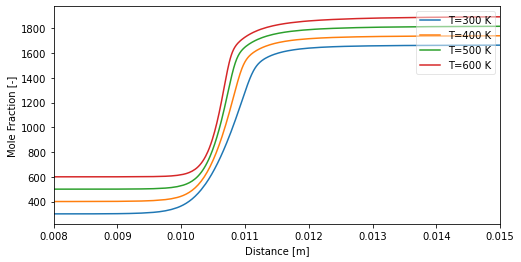

In [26]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
plt.xlim(0.008,0.015)
plt.plot(flamelist[0].grid,flamelist[0].T,label='T=300 K')
plt.plot(flamelist[1].grid,flamelist[1].T,label='T=400 K')
plt.plot(flamelist[2].grid,flamelist[2].T,label='T=500 K')
plt.plot(flamelist[3].grid,flamelist[3].T,label='T=600 K')
plt.xlabel('Distance [m]')
plt.ylabel('Mole Fraction [-]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper right')

We are going to create an FGM for use in Fluent
First we need to create the header of the file with all the info on the stored data.
Then, we write the FGM data as column data in the ASCII file

In [244]:
# we are going to write the solution as an FGM to a datafile

# points in progress variable direction
pvpoints = len(f.X[0])
# points in enthalpy direction
enthpoints = 2

strdatasize=str(pvpoints) + " " + str(enthpoints) + " \n"
strgridpower="1.0 1.0 \n"
strpoints=str(pvpoints) + " " + str(enthpoints)
print(strpoints)

fgmheader=["[FGM] \n",
           "2DRLR \n",
           "[DIMENSION] \n",
           "2 \n",
           "[CVDEFINITION] \n",
           "2 \n",
           "CO2  1.0 0.0 \n",
           "ENTHALPY 0.0 1.0 \n",
           "[END] \n",
           "[DATASIZE] \n", 
           strdatasize, 
           "[GRIDPOWER] \n", 
           strgridpower,
           "VARIABLES \n",]

varlist=["CV1 \n",
         "CV2 \n",
         "SOURCE_CV1 \n",
         "SOURCE_CV2 \n",
         "DIFF_CV1 \n",
         "DIFF_CV2 \n",
         "DENSITY \n",
         "TEMPERATURE \n",
         "CP \n",
         "CONDUCTIVITY \n", 
         "VISCOSITY \n", 
         "HEATRELEASE \n"]

print(varlist)

for i, specie in enumerate(gas.species()):
    varlist.append(str(specie).replace('<Species ','').replace('>','')+" \n")

varlist.append("ENTHALPY \n")
print(varlist)

# number of variables
numvar = len(varlist)
print(numvar)

fgmheader.append(str(numvar)+" \n")
fgmheader = fgmheader + varlist
fgmheader.append("[END] \n")
fgmheader.append("[DATA] \n")

print(fgmheader)
CP=np.array(f.cp_mass)
CONDUCTIVITY=np.array(f.thermal_conductivity)
DENSITY=np.array(f.density)
DIFF = CONDUCTIVITY/CP
DIFF=DIFF/DENSITY

# index to the species that acts as a progress variable
iPV=5
ENTHALPY = f.enthalpy_mass
# first control variable: progress variable
CV1=f.Y[iPV]
# second control variable: enthalpy
CV2=ENTHALPY

SOURCE_CV1 = f.net_production_rates[iPV]
SOURCE_CV2 = 0
CONDUCTIVITY=np.array(f.thermal_conductivity)
CP=np.array(f.cp_mass)
DENSITY=np.array(f.density)
DIFF_CV1 = CONDUCTIVITY/CP
DIFF_CV1 = DIFF_CV1/DENSITY
DIFF_CV2 = DIFF_CV1
VISCOSITY=f.viscosity
TEMPERATURE=f.T
HEATRELEASE=f.heat_release_rate

# which species do we want to write to the FGM?
SPECIES1 = f.X[gas.species_index("H2O")]
SPECIES2 = f.X[gas.species_index("CH4")]
SPECIES3 = f.X[gas.species_index("O2")]
SPECIES4 = f.X[gas.species_index("H2")]
SPECIES5 = f.X[gas.species_index("CO")]
SPECIES6 = f.X[gas.species_index("CO2")]
SPECIES7 = f.X[gas.species_index("OH")]
SPECIES8 = f.X[gas.species_index("CH")]
SPECIES9 = f.X[gas.species_index("NO")]

import csv
# open the file for writing, create if file does not exist, overwrite if file exists
fgmfile = open("fgm.dat","w",newline='')

# write the header
fgmfile.writelines(fgmheader)

# write the data, loop over the enthalpy points
# for i in range
# write the data, loop over the progress variable points
for i in range(0,pvpoints):
    fgmline = [i,CV1[i],CV2[i],SOURCE_CV1[i],SOURCE_CV2,DIFF_CV1[i],DIFF_CV2[i],DENSITY[i],TEMPERATURE[i],CP[i],VISCOSITY[i],HEATRELEASE[i],SPECIES1[i],SPECIES2[i],SPECIES3[i],SPECIES4[i],SPECIES5[i],SPECIES6[i],SPECIES7[i],SPECIES8[i],SPECIES9[i],ENTHALPY[i]]
    #fgmline = [str(item)+' ' for item in fgmlist]
    #fgmline.append("\n")
    #print(fgmline
    #fgmfile.writelines(line)
    wr=csv.writer(fgmfile,delimiter=' ',lineterminator='\n')
    wr.writerow(item for item in fgmline)
    
fgmfile.write("[END]")
fgmfile.close()

173 2
['CV1 \n', 'CV2 \n', 'SOURCE_CV1 \n', 'SOURCE_CV2 \n', 'DIFF_CV1 \n', 'DIFF_CV2 \n', 'DENSITY \n', 'TEMPERATURE \n', 'CP \n', 'CONDUCTIVITY \n', 'VISCOSITY \n', 'HEATRELEASE \n']
['CV1 \n', 'CV2 \n', 'SOURCE_CV1 \n', 'SOURCE_CV2 \n', 'DIFF_CV1 \n', 'DIFF_CV2 \n', 'DENSITY \n', 'TEMPERATURE \n', 'CP \n', 'CONDUCTIVITY \n', 'VISCOSITY \n', 'HEATRELEASE \n', 'H2 \n', 'H \n', 'O \n', 'O2 \n', 'OH \n', 'H2O \n', 'HO2 \n', 'H2O2 \n', 'C \n', 'CH \n', 'CH2 \n', 'CH2(S) \n', 'CH3 \n', 'CH4 \n', 'CO \n', 'CO2 \n', 'HCO \n', 'CH2O \n', 'CH2OH \n', 'CH3O \n', 'CH3OH \n', 'C2H \n', 'C2H2 \n', 'C2H3 \n', 'C2H4 \n', 'C2H5 \n', 'C2H6 \n', 'HCCO \n', 'CH2CO \n', 'HCCOH \n', 'N \n', 'NH \n', 'NH2 \n', 'NH3 \n', 'NNH \n', 'NO \n', 'NO2 \n', 'N2O \n', 'HNO \n', 'CN \n', 'HCN \n', 'H2CN \n', 'HCNN \n', 'HCNO \n', 'HOCN \n', 'HNCO \n', 'NCO \n', 'N2 \n', 'AR \n', 'C3H7 \n', 'C3H8 \n', 'CH2CHO \n', 'CH3CHO \n', 'ENTHALPY \n']
66
['[FGM] \n', '2DRLR \n', '[DIMENSION] \n', '2 \n', '[CVDEFINITION] \n', '

[<Species H2>,
 <Species H>,
 <Species O>,
 <Species O2>,
 <Species OH>,
 <Species H2O>,
 <Species HO2>,
 <Species H2O2>,
 <Species C>,
 <Species CH>,
 <Species CH2>,
 <Species CH2(S)>,
 <Species CH3>,
 <Species CH4>,
 <Species CO>,
 <Species CO2>,
 <Species HCO>,
 <Species CH2O>,
 <Species CH2OH>,
 <Species CH3O>,
 <Species CH3OH>,
 <Species C2H>,
 <Species C2H2>,
 <Species C2H3>,
 <Species C2H4>,
 <Species C2H5>,
 <Species C2H6>,
 <Species HCCO>,
 <Species CH2CO>,
 <Species HCCOH>,
 <Species N>,
 <Species NH>,
 <Species NH2>,
 <Species NH3>,
 <Species NNH>,
 <Species NO>,
 <Species NO2>,
 <Species N2O>,
 <Species HNO>,
 <Species CN>,
 <Species HCN>,
 <Species H2CN>,
 <Species HCNN>,
 <Species HCNO>,
 <Species HOCN>,
 <Species HNCO>,
 <Species NCO>,
 <Species N2>,
 <Species AR>,
 <Species C3H7>,
 <Species C3H8>,
 <Species CH2CHO>,
 <Species CH3CHO>]

In [257]:
dir(gas)

['DP',
 'DPX',
 'DPY',
 'HP',
 'HPX',
 'HPY',
 'ID',
 'P',
 'P_sat',
 'SP',
 'SPX',
 'SPY',
 'SV',
 'SVX',
 'SVY',
 'T',
 'TD',
 'TDX',
 'TDY',
 'TP',
 'TPX',
 'TPY',
 'T_sat',
 'UV',
 'UVX',
 'UVY',
 'X',
 'Y',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_check_kinetics_species_index',
 '_check_phase_index',
 '_check_reaction_index',
 '_full_states',
 '_init_cti_xml',
 '_init_parts',
 '_references',
 'activities',
 'activity_coefficients',
 'add_reaction',
 'add_species',
 'atomic_weight',
 'atomic_weights',
 'basis',
 'binary_diff_coeffs',
 'chemical_potentials',
 'concentrations',
 'cp',
 'cp_mass',
 'cp_mole',
 'cr

In [251]:
gas.species().index("Species O2>")

ValueError: 'Species O2>' is not in list

In [269]:
gas.species_index("H2O")

5

In [270]:
gas.n_species

53